#Лабораторная работа №6

#Введние

В данной лабораторной работе требуется:
1. Найти датасет на hugginface или kaggle. В датасете обязательно должны быть временные метки.
2. На основе этого датасета необходимо построить рекурсивную или губридную модель прогнозирования одного из представленных в нем признаков

Будем использовать датасет с kaggle с температурой в крупных городах. Будем предсказывать температуру

Ссылка: https://www.kaggle.com/datasets/sudalairajkumar/daily-temperature-of-major-cities

#Реализация

Импортируем библиотеки

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import warnings

Загрузка датасета

In [ ]:
df = pd.read_csv('city_temperature.csv')
print(f"Размер датасета: {df.shape}")
print(f"Столбцы: {df.columns.tolist()}")


/tmp/ipython-input-1855571137.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('city_temperature.csv')


Размер датасета: (2906327, 8)
Столбцы: ['Region', 'Country', 'State', 'City', 'Month', 'Day', 'Year', 'AvgTemperature']


Посмотрим на пропуски в данных

In [ ]:
print(df.isnull().sum())

Region                  0
Country                 0
State             1450990
City                    0
Month                   0
Day                     0
Year                    0
AvgTemperature          0
dtype: int64


Согласно данным с kaggle, в колонке State около 50% пропусков, поэтому данную колонку лучше удалить.

In [ ]:
df = df.drop('State', axis=1)

Посмотрим остались ли пропуски

In [ ]:
print(df.isnull().sum())

Region            0
Country           0
City              0
Month             0
Day               0
Year              0
AvgTemperature    0
dtype: int64


Пропусков нет

Будем предсказывать температуру для Москвы

In [ ]:
moscow_data = df[df['City'] == 'Moscow'].copy()

Преобразуем дату

In [ ]:
moscow_data['Date'] = pd.to_datetime(moscow_data[['Year', 'Month', 'Day']])
moscow_data = moscow_data.drop(columns=['Year', 'Month', 'Day'])

Переведем температуру в градусы цельсия, и уберем выбросы

In [ ]:
moscow_data_temp = df[df['City'] == 'Moscow'].copy()

moscow_data['AvgTemperature'] = (moscow_data_temp['AvgTemperature'] - 32) * 5/9
moscow_data = moscow_data[moscow_data['AvgTemperature'].between(-45, 40)]

Посмотрим как изменялась температура

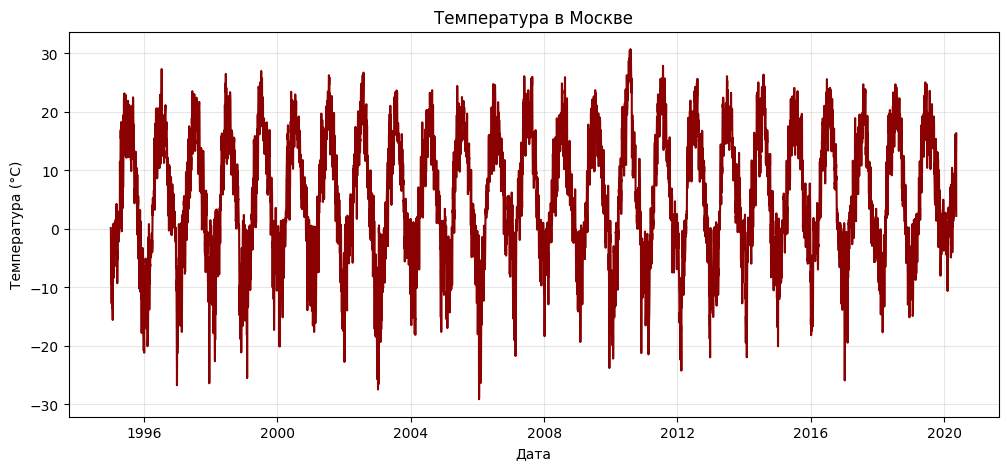

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(moscow_data['Date'], moscow_data['AvgTemperature'], linewidth=1.5, color='darkred')
plt.title('Температура в Москве')
plt.xlabel('Дата')
plt.ylabel('Температура (°C)')
plt.grid(True, alpha=0.3)
plt.show()

Делим данные

In [ ]:
n = len(moscow_data)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

train_data = moscow_data.iloc[:train_end]
val_data = moscow_data.iloc[train_end:val_end]
test_data = moscow_data.iloc[val_end:]

print(f"Train: {len(train_data)} записей")
print(f"Validation: {len(val_data)} записей")
print(f"Test: {len(test_data)} записей")

Train: 5541 записей
Validation: 1847 записей
Test: 1847 записей


Масштабируем

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

# Масштабируем тренировочные данные
train_scaled = scaler.fit_transform(train_data[['AvgTemperature']])
val_scaled = scaler.transform(val_data[['AvgTemperature']])
test_scaled = scaler.transform(test_data[['AvgTemperature']])

Создаем последовательности

In [ ]:
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60
X_train, y_train = create_sequences(train_scaled, SEQ_LENGTH)
X_val, y_val = create_sequences(val_scaled, SEQ_LENGTH)
X_test, y_test = create_sequences(test_scaled, SEQ_LENGTH)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (5481, 60, 1)
y_train shape: (5481, 1)
X_val shape: (1787, 60, 1)
X_test shape: (1787, 60, 1)


Строим модель

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential([
    # Первый LSTM слой
    LSTM(100, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),

    # Второй LSTM слой
    LSTM(50, return_sequences=False),
    Dropout(0.2),

    # Полносвязные слои
    Dense(25, activation='relu'),
    Dense(1)  # Выход - температура
])

model.compile(
    optimizer='adam',
    loss='mse',  # Mean Squared Error для регрессии
    metrics=['mae']  # Mean Absolute Error
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Обучаем

In [ ]:
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - loss: 0.0076 - mae: 0.0689 - val_loss: 0.0073 - val_mae: 0.0701
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - loss: 0.0071 - mae: 0.0661 - val_loss: 0.0042 - val_mae: 0.0508
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - loss: 0.0061 - mae: 0.0613 - val_loss: 0.0042 - val_mae: 0.0514
Epoch 4/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - loss: 0.0055 - mae: 0.0581 - val_loss: 0.0043 - val_mae: 0.0531
Epoch 5/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - loss: 0.0048 - mae: 0.0543 - val_loss: 0.0045 - val_mae: 0.0550
Epoch 6/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - loss: 0.0041 - mae: 0.0498 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 7/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - loss: 0.0040 - mae: 0.0498 - val_loss: 0.0032 - val_mae: 0.0458
Epoch 8/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - loss: 0.0035 - mae: 0.0459 - val_loss: 0.0045 - val_mae: 0.0562
Epoch 9/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 

Проверяем точность

In [ ]:
y_pred = scaler.inverse_transform(model.predict(X_test))
y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

mae_celsius = mean_absolute_error(y_true, y_pred)
print(f"MAE: {mae_celsius:.2f}°C")

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
MAE: 2.19°C


Средняя ошибка прогноза составила 2.19°C, что сравнимо с точностью суточных прогнозов погоды.

#Заключение

Проделав данную работу, была построена рекуррентная модель прогнозирования температуры в Москве, достигшая средней абсолютной ошибки 2.19°C, что соответствует точности суточных метеорологических прогнозов. Применение LSTM-архитектуры позволило эффективно обрабатывать временные последовательности данных.